In [2]:
#installing packages
install.packages("tree")
install.packages("randomForest")
install.packages("gbm")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [3]:
#loading libraries
library(tree)
library(randomForest)
library(gbm)

randomForest 4.7-1.1

Type rfNews() to see new features/changes/bug fixes.

Loaded gbm 2.1.8.1



In [4]:
#loading data
data = read.csv("USA_Housing.csv", sep = ",", header = TRUE)

In [5]:
#cleaning data
data = subset(data, select = -c(Address))
head(data,n = 10)
sum(is.na(data))

colnames(data) <- c("A.Income", "A.house.age", "A.num.rooms",
                    "A.num.bedrooms","Population","Price")
names(data)

,Avg..Area.Income,Avg..Area.House.Age,Avg..Area.Number.of.Rooms,Avg..Area.Number.of.Bedrooms,Area.Population,Price
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,79545.46,5.682861,7.009188,4.09,23086.80,1059033.6
2,79248.64,6.002900,6.730821,3.09,40173.07,1505890.9
3,61287.07,5.865890,8.512727,5.13,36882.16,1058988.0
4,63345.24,7.188236,5.586729,3.26,34310.24,1260616.8
5,59982.20,5.040555,7.839388,4.23,26354.11,630943.5
6,80175.75,4.988408,6.104512,4.04,26748.43,1068138.1
7,64698.46,6.025336,8.147760,3.41,60828.25,1502055.8
8,78394.34,6.989780,6.620478,2.42,36516.36,1573936.6
9,59927.66,5.362126,6.393121,2.30,29387.40,798869.5


[1] 0

[1] "A.Income"       "A.house.age"    "A.num.rooms"    "A.num.bedrooms"
[5] "Population"     "Price"

In [6]:
###splitting data into trainnig and test data
set.seed(1)
train <- sample(1:nrow(data), nrow(data) / 2)
data.test <- data[-train, "Price"]

In [7]:
#linear model using least squares on the training set
lm.fit <- lm(Price~., data, subset =  train)
lm.pred  <- predict(lm.fit,data,subset= data.test)
price.test <- data$Price[-train]
MSE.lm <- mean((lm.pred -price.test )^2) #warning message due to length dimensions
MSE.lm

[1] 236403793050

In [8]:
## Fitting Regression Trees
# fitting the tree regression on the training dataset
tree.data <- tree(Price ~ ., data, subset = train)
summary(tree.data)


Regression tree:
tree(formula = Price ~ ., data = data, subset = train)
Variables actually used in tree construction:
[1] "A.Income"    "A.house.age" "Population" 
Number of terminal nodes:  14 
Residual mean deviance:  4.563e+10 = 1.134e+14 / 2486 
Distribution of residuals:
     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
-744300.0 -147500.0     810.9       0.0  143300.0  658800.0 

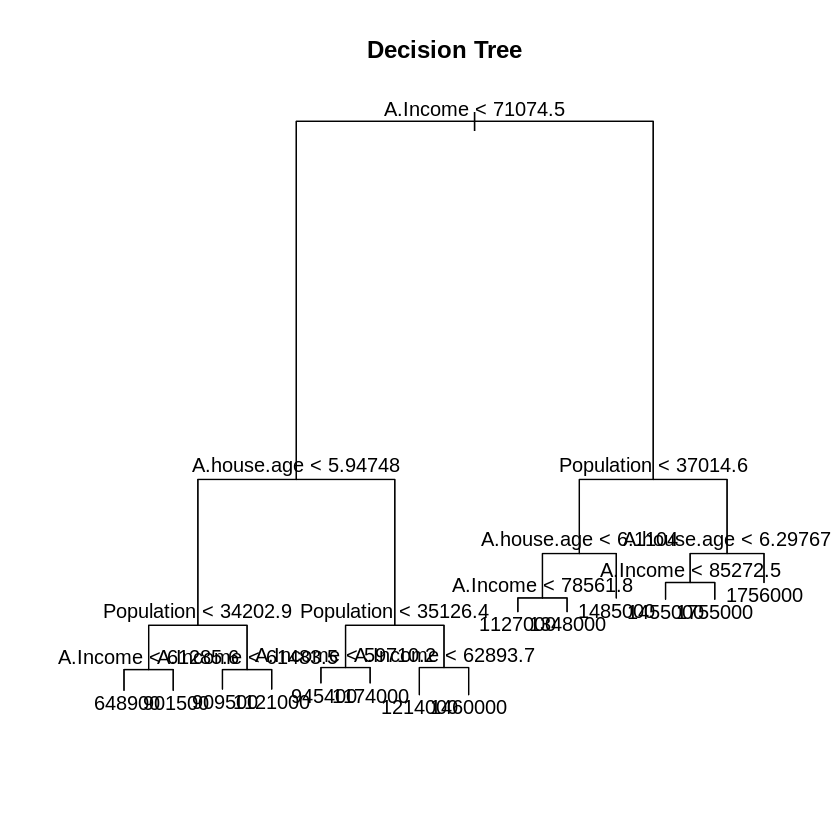

In [9]:
###plotting the training the tree
plot(tree.data)
text(tree.data, pretty = 0)
title("Decision Tree")

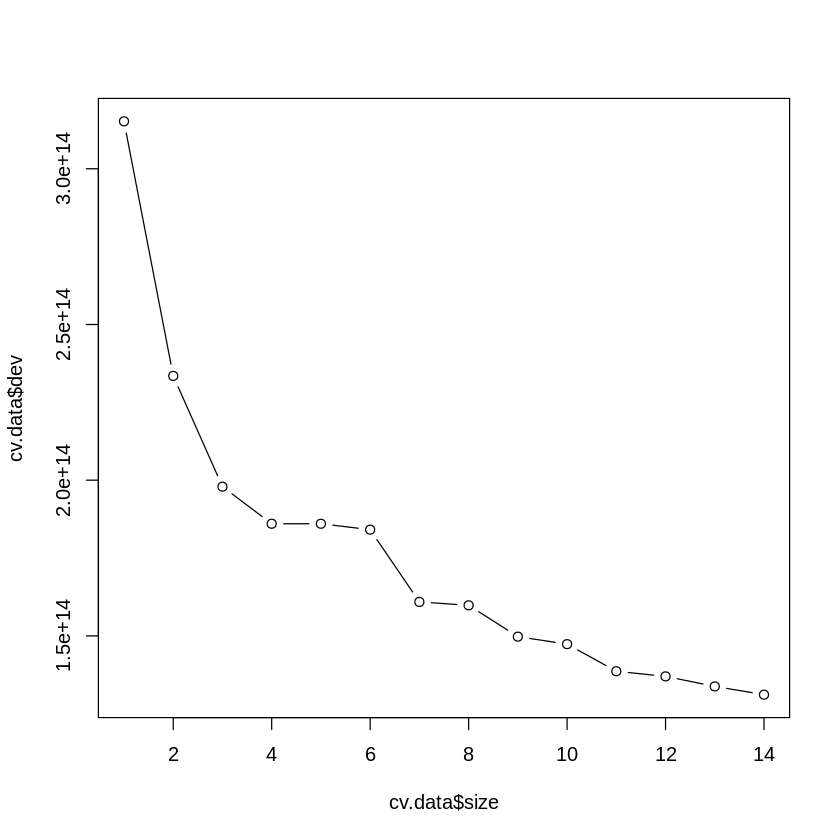

In [10]:
###plotting out the CV
cv.data <- cv.tree(tree.data)
#par(mfrow = c(1,2))
plot(cv.data$size, cv.data$dev, type = "b")

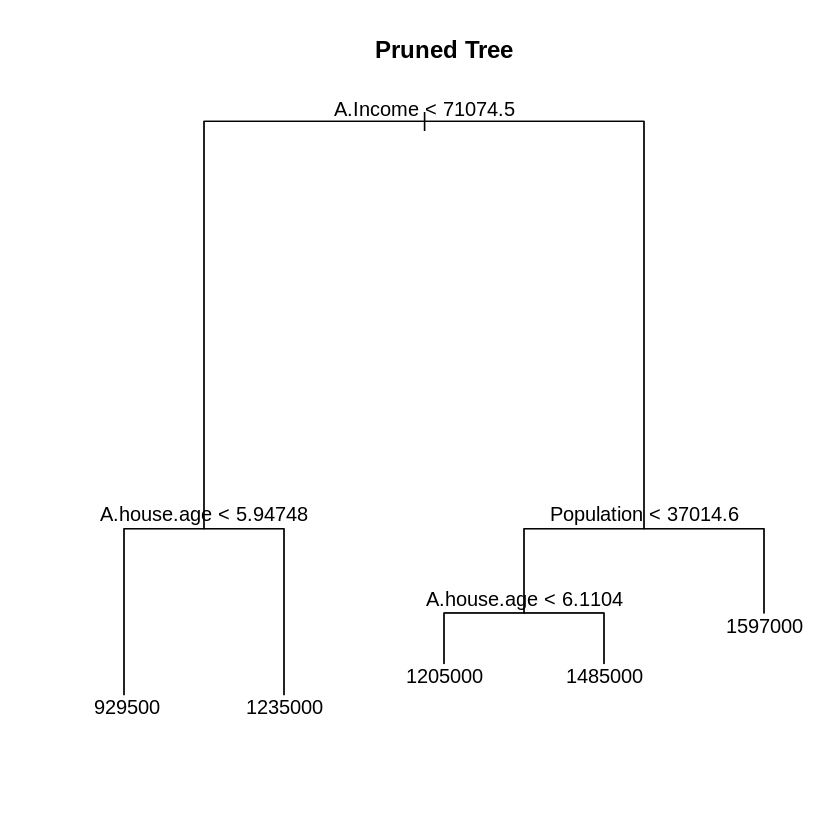

In [11]:
###pruning the tree
prune.data <- prune.tree(tree.data, best = 5)
plot(prune.data)
text(prune.data, pretty = 0)
title("Pruned Tree")

[1] 50849447158

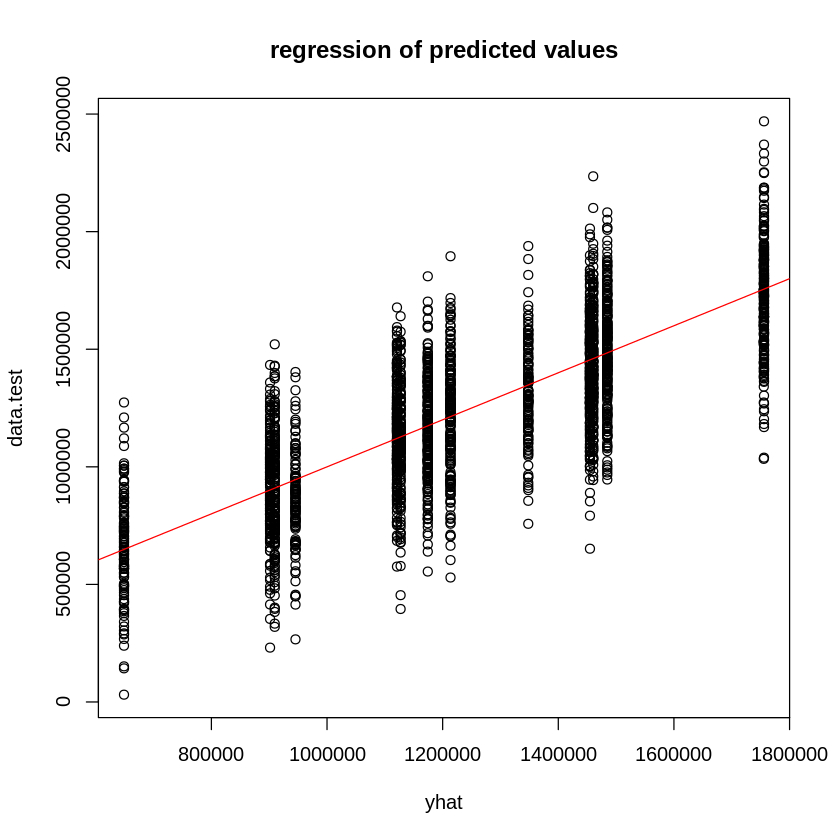

In [12]:
###unpruning to take predictions
yhat <- predict(tree.data, newdata = data[-train, ])
plot(yhat, data.test)
abline(0, 1, col = "red")
title("regression of predicted values")
MSE.tree = mean((yhat - data.test)^2)
MSE.tree

In [13]:
## Bagging and Random Forests
#considering all 5 predictors
set.seed(1)
bag.data<- randomForest(Price ~ ., data = data,
                           subset = train, mtry = 5, importance = TRUE)
bag.data


Call:
 randomForest(formula = Price ~ ., data = data, mtry = 5, importance = TRUE,      subset = train) 
               Type of random forest: regression
                     Number of trees: 500
No. of variables tried at each split: 5

          Mean of squared residuals: 15049552161
                    % Var explained: 88.05

[1] 15445301668

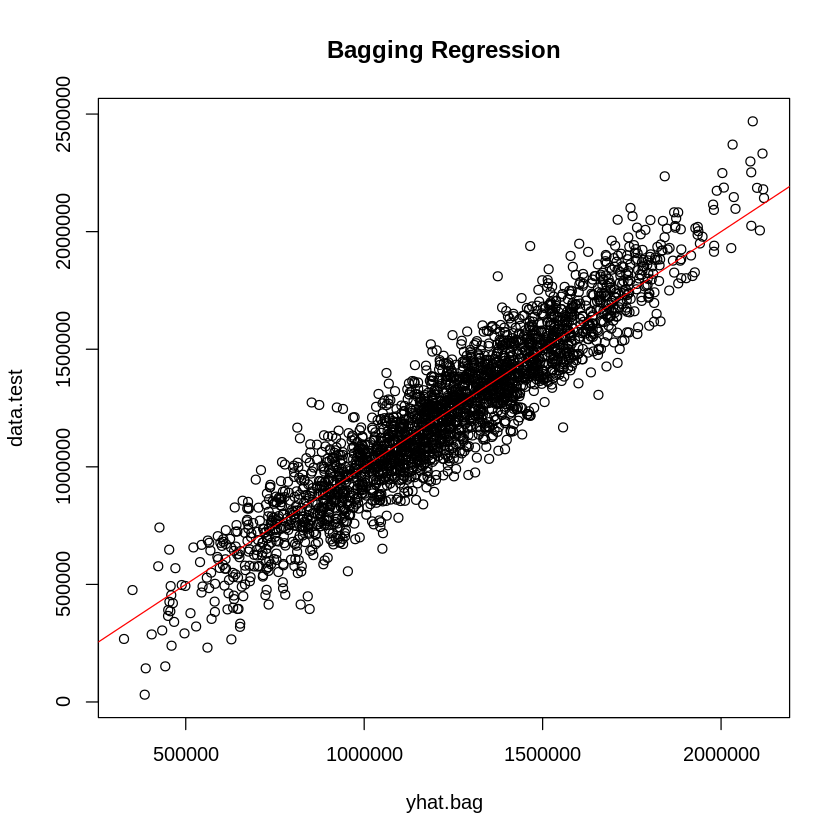

In [14]:
###fitting the bagging model on train data and calculating the MSE
yhat.bag <- predict(bag.data, newdata = data[-train, ])
plot(yhat.bag, data.test)
abline(0, 1, col = "red")
title("Bagging Regression")
MSE.bag = mean((yhat.bag - data.test)^2)
MSE.bag

In [15]:
### changing the number of trees grown
bag.data<- randomForest(Price ~ ., data = data,
                           subset = train, mtry = 5, ntree = 25)
yhat.bag <- predict(bag.data, newdata = data[-train, ])
MSE.bag.ntree = mean((yhat.bag - data.test)^2)
MSE.bag.ntree

[1] 16323482444

In [16]:
###Random Forest
set.seed(1)
rf.data<- randomForest(Price ~ ., data = data,
                          subset = train, mtry = 3, importance = TRUE)
yhat.rf <- predict(rf.data, newdata = data[-train, ])
MSE.random = mean((yhat.rf - data.test)^2)
MSE.random

[1] 15504292616

In [17]:
### imporatance of each variable
importance(rf.data)

,%IncMSE,IncNodePurity
A.Income,331.65238,1.333121e+14
A.house.age,246.87246,7.353533e+13
A.num.rooms,156.63815,3.593121e+13
A.num.bedrooms,15.55298,7.469869e+12
Population,222.83076,6.133939e+13


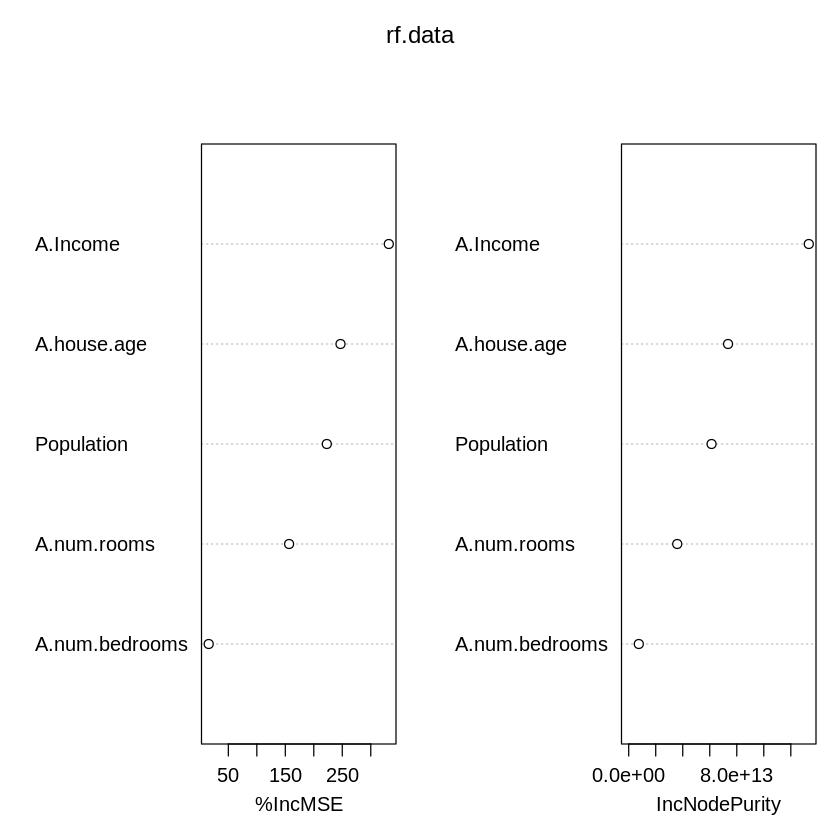

In [18]:
varImpPlot(rf.data)

,var,rel.inf
,<chr>,<dbl>
A.Income,A.Income,37.643913
A.house.age,A.house.age,22.748746
Population,Population,20.634576
A.num.rooms,A.num.rooms,14.517757
A.num.bedrooms,A.num.bedrooms,4.455008


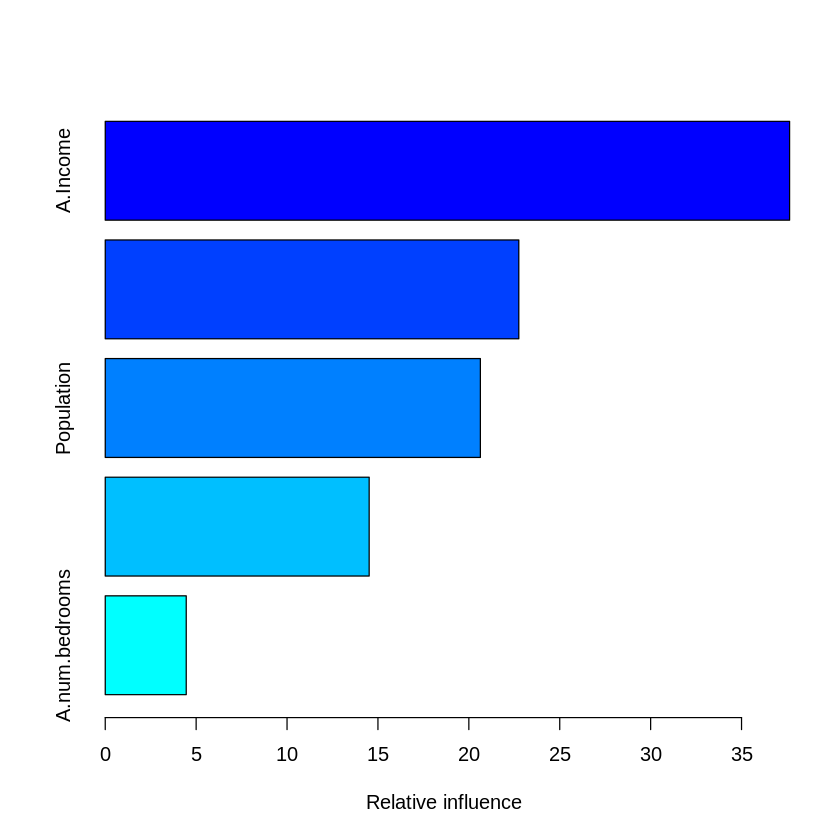

In [19]:
## Boosting
set.seed(1)
boost.data <- gbm(Price ~ ., data = data[train, ],
                    distribution = "gaussian", n.trees = 5000,
                    interaction.depth = 4)
summary(boost.data)

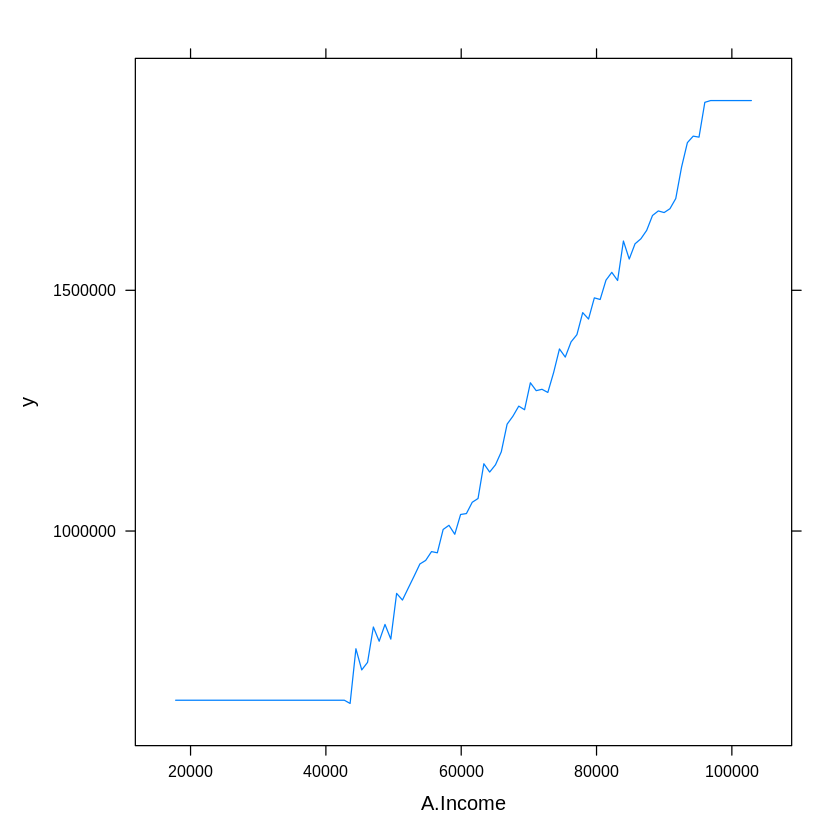

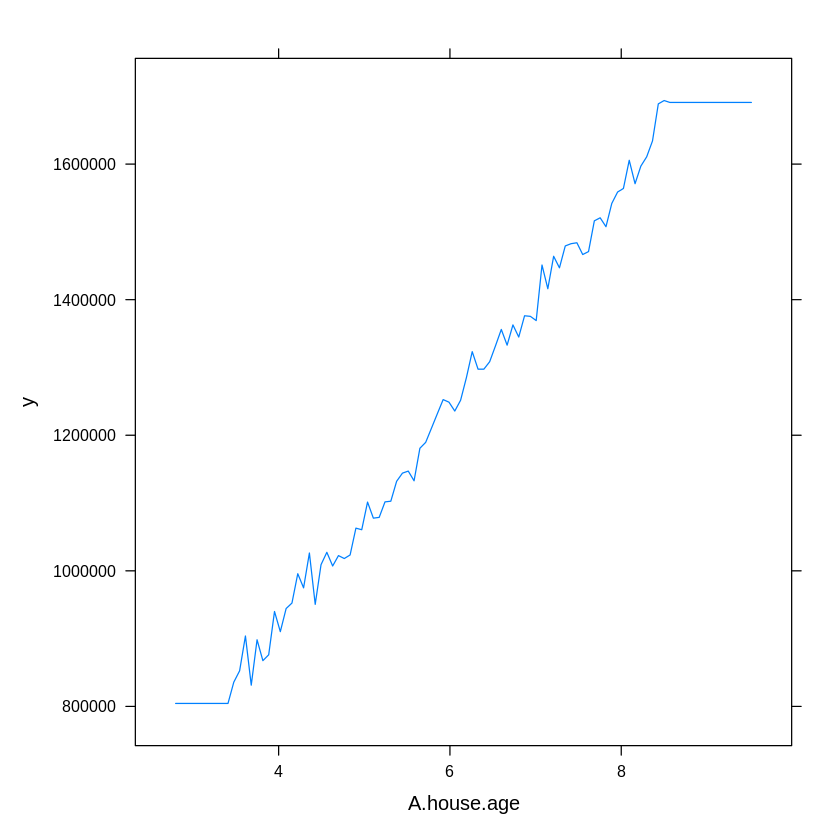

In [20]:
### plotting the top 2 most important variables
plot(boost.data, i = "A.Income")
plot(boost.data, i = "A.house.age")

In [21]:
### using boosted model to predict Price on the test set
yhat.boost <- predict(boost.data,
                      newdata = data[-train, ], n.trees = 5000)
MSE.boost = mean((yhat.boost - data.test)^2)
MSE.boost

[1] 14855130713

In [22]:
### USing a shrinking parameter with default value is 0.2 (λ)
boost.data <- gbm(Price ~ ., data = data[train, ],
                    distribution = "gaussian", n.trees = 5000,
                    interaction.depth = 4, shrinkage = 0.2, verbose = F)
yhat.boost <- predict(boost.data,
                      newdata = data[-train, ], n.trees = 5000)
MSE.boost.shrink = mean((yhat.boost - data.test)^2)
MSE.boost.shrink

[1] 16674614031

In [23]:
### Saving all results in a data frame
MSE.all = data.frame(cbind(MSE.tree, MSE.bag,MSE.bag.ntree, MSE.random,MSE.boost,
                           MSE.boost.shrink), row.names = "MSE")
colnames(MSE.all) = c("tree", "bagging", "bagging.num.tree", "random.forest",
                      "boosting","boosting.shrink")
MSE.all

,tree,bagging,bagging.num.tree,random.forest,boosting,boosting.shrink
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
MSE,50849447158,15445301668,16323482444,15504292616,14855130713,16674614031
